# EDA Prep FE 2nd

### 목표

- 아파트 아이디 변환 : 순서가 있는 int형 카테고리
- null data 추정 : 그리드 서치로 lgb 파라미터 조절한 다음 바로 추정
- school, subway : eda

### 결과

- 아파트 아이디 변환 : test에만 있는 12개 단지는 mid값으로 넣음
- null data 추정 : 그리드 서치로 lgb 파라미터 조절한 다음 바로 추정

##### subway

- 역세권
    - 1차 : 200m
    - 2차 : 500m
    - 3차 : 800m : 1km가 아닌 이유 : 단순히 직선거리로 재기 때문에 실소요거리는 더 길 것임
- 더블 역세권
    - 환승역
    - 나머지는 기준이 애매함. 일단 3차도 도보 10분 이내이므로 3차까지 포함해서 계산
- 지하철역의 가치 : logPrice
    - 역세권에 속하는 단지 아이디의 타겟값을 활용해서 지하철역의 가치를 계산할 수 있음
    - 예) 강남역, 판교역 등은 다른 역주변보다 비쌈
- 지하철역 구/동 : disTown - 법정동코드 000000 형태
- 환승역 갯수 : noLine
    
##### school

- private
- onlySex

### 부족한 부분

- 아파트 단지와 지하철/학교와의 거리 구하기 연산 시간 너무 길다...

### 새로운 아이디어

- 평당가를 구하자
- 법정동 가치 구하기 : 평당가를 활용해서 가치 산출
    - 지하철 가치 산출 가능
    - 학교 가치 산출 가능

In [2]:
import pandas as pd
import numpy as np
import os, sys, warnings, re, time, gc,math
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

warnings.filterwarnings('ignore')
sys.path.append(os.path.abspath(os.path.dirname('../')))
from modules import eda
gc.collect()

0

In [30]:
# path = './datasets/'
# train = pd.read_csv(path+'trainFe1st.csv')
# test = pd.read_csv(path+'testFe1st.csv')
school = pd.read_csv(path+'origin/Schools.csv')
# subway = pd.read_csv(path+'origin/Subways.csv')

In [7]:
# train.to_csv('./datasets/trainFE2nd.csv', index=False)
# test.to_csv('./datasets/testFE2nd.csv', index=False)
# subway.to_csv('./datasets/subwayFE1st.csv', index=False)
subDist.to_csv('./datasets/subDist.csv', index=False)

In [14]:
def colInfo(col, train=train):
    dtype = train[col].dtypes
    print(dtype)
    if dtype == 'float64' : 
        print(train[col].describe())
    else:
        uniq = train[col].unique()
        if dtype == 'O' or len(uniq)<100: 
            print(train[col].value_counts(dropna=False))
        else : 
            print(train[col].describe())
    isna(col, train)
            
def isna(col, train=train):
    print('train na : ', sum(train[col].isna()))


In [5]:
# 연산용 코드모음
apart = 'apartment_id'
target = 'logPrice'
lat = 'latitude'
lot = 'longitude'
allUniq = list(set(train[apart].unique().tolist()+test[apart].unique().tolist()))
mid = (len(allUniq)-12)//2
onlyTest = list(set(test[apart].unique())-set(train[apart].unique()))

# 아파트명 순서가 있는 int형 index로 변형
meanApart = train[[target, apart]].groupby([apart]).agg('mean')
meanApart=meanApart.sort_values(by=[target])
apartCnvt = {}
apartId = meanApart.index.tolist()
for i in range(mid):
    apartCnvt[apartId[i]] = i+1
for i in range(12):
    apartCnvt[onlyTest[i]] = mid+i+1
for i in range(mid, mid*2):
    apartCnvt[apartId[i]] = i+13
train['apart'] = train[apart].apply(lambda row : apartCnvt[row])
test['apart'] = test[apart].apply(lambda row : apartCnvt[row])

# # 지하철 역과의 거리 구하기
# station = subway['station_id'].tolist()
# apartId = test[apart].unique().tolist()
# subDict = {}
# length = len(apartId)
# for stat in station:
#     subDict[stat] = [None for i in range(length)]
# subDist = pd.DataFrame(subDict, index=apartId)
# apartLoc = test[[apart, lat, lot]].groupby([apart]).agg('mean')
# statLoc = subway[['station_id', lat, lot]].groupby(['station_id']).agg('mean')
# for s in station:
#     for a in apartId:
#         width = (statLoc.loc[s, lat] - apartLoc.loc[a, lat])*88740
#         height = (statLoc.loc[s, lot] - apartLoc.loc[a, lot])*110000
#         subDist.loc[a, s]=math.sqrt(width**2+height**2)

# 지하철역 구/동 위치 구하기
disTownPrice = train[['disTown', target]].groupby(['disTown']).agg(['mean','median'])
def disTownCnvrt(x):
    try : return int(str(x)[2:8])
    except ValueError : return np.nan
subway['disTown'] = subway['address_by_law'].apply(lambda row : disTownCnvrt(row))

# 지하철역 가치 구하기
def priceCnvrt(x):
    try : return disTownPrice[target]['median'][int(x)]
    except KeyError : return np.nan
    except ValueError : return np.nan
subway[target] = subway['disTown'].apply(lambda row : priceCnvrt(row))

# 지하철역 노선 갯수
subway['noLine'] = subway['subway_line'].apply(lambda row : len(row.split(',')))

## Apartment id

In [5]:
apart = 'apartment_id'
target = 'logPrice'
train[target] = np.log(train['transaction_real_price'])
train.to_csv('./datasets/trainFe1st.csv', index=False)

In [18]:
allUniq = list(set(train[apart].unique().tolist()+test[apart].unique().tolist()))
print(len(allUniq))
print('only test', set(test[apart].unique())-set(train[apart].unique()))
print('only train', set(train[apart].unique())-set(test[apart].unique()))
mid = (len(allUniq)-12)//2
print(mid)

3918
only test {36224, 38465, 22247, 36841, 37353, 37354, 37297, 37431, 26553, 37180, 33373, 37086}
only train set()
1953


In [8]:
onlyTest = list(set(test[apart].unique())-set(train[apart].unique()))
midApart = train[[target, apart]].groupby([apart]).agg('median')
meanApart = train[[target, apart]].groupby([apart]).agg('mean')
print(midApart.head(10))
print(meanApart.head(10))

3906
               logPrice
apartment_id           
3             20.401682
4             20.069339
5             20.125429
24            18.792244
26            21.045349
30            20.431576
31            21.274273
32            21.091375
33            20.426868
34            20.474804
               logPrice
apartment_id           
3             20.382581
4             20.045308
5             20.177104
24            18.682810
26            21.026528
30            20.425086
31            21.239399
32            21.061784
33            20.453365
34            20.489188


Skewed:  -0.07944718426559089
Kurtosis:  0.2178878686573391


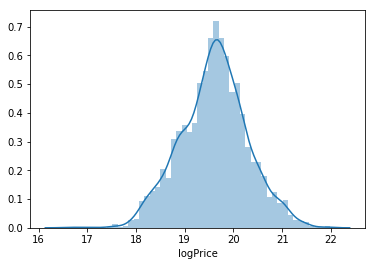

In [12]:
sns.distplot(midApart[target])
print("Skewed: ", midApart[target].skew())
print("Kurtosis: ", midApart[target].kurt())

Skewed:  -0.08724618280060677
Kurtosis:  0.08632898784966159


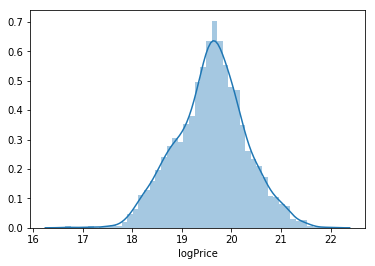

In [11]:
sns.distplot(meanApart[target])
print("Skewed: ", meanApart[target].skew())
print("Kurtosis: ", meanApart[target].kurt())

In [19]:
meanApart=meanApart.sort_values(by=[target])
apartCnvt = {}
apartId = meanApart.index.tolist()
for i in range(mid):
    apartCnvt[apartId[i]] = i+1
for i in range(12):
    apartCnvt[onlyTest[i]] = mid+i+1
for i in range(mid, mid*2):
    apartCnvt[apartId[i]] = i+13
print(len(set(apartCnvt.keys())))

3918


In [21]:
train['apart'] = train[apart].apply(lambda row : apartCnvt[row])
test['apart'] = test[apart].apply(lambda row : apartCnvt[row])

## Subway

In [22]:
subway.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405 entries, 0 to 404
Data columns (total 5 columns):
station_id        405 non-null int64
latitude          405 non-null float64
longitude         405 non-null float64
subway_line       405 non-null object
address_by_law    396 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 15.9+ KB


### 지하철역 거리 구하기

In [9]:
%%time
# 위도 1도 : 110,000m
# 경도 1도 : 88,740m
# station = subway['station_id'].tolist()
# apartId = test[apart].unique().tolist()
# subDict = {}
# length = len(apartId)
for stat in station:
    subDict[stat] = [None for i in range(length)]
subDist = pd.DataFrame(subDict, index=apartId)

# lat = 'latitude'
# lot = 'longitude'
# apartLoc = test[[apart, lat, lot]].groupby([apart]).agg('mean')
# statLoc = subway[['station_id', lat, lot]].groupby(['station_id']).agg('mean')
for s in tqdm(station):
    for a in apartId:
        width = (statLoc.loc[s, lat] - apartLoc.loc[a, lat])*110000
        height = (statLoc.loc[s, lot] - apartLoc.loc[a, lot])*88740
        subDist.loc[a, s]=math.sqrt(width**2+height**2)

  0%|                                          | 1/405 [01:46<11:59:32, 106.86s/it]

KeyboardInterrupt: 

In [ ]:
subDist = subDist.T
for u in allUniq:
    test

### 지하철역 가치 구하기

In [42]:
disTownPrice = train[['disTown', target]].groupby(['disTown']).agg(['mean','median'])
disTownPrice

logPrice           
              mean     median
disTown                      
110101   18.667098  18.683045
110102   17.989931  17.989898
110115   20.245029  20.560747
110118   20.740151  20.762487
110120   18.835167  18.951309
110133   19.102234  19.091068
110137   19.228001  19.231364
110157   20.102490  20.088388
110171   19.986549  20.084607
110174   19.527896  19.552083
110175   20.031233  20.063069
110177   20.915938  20.938377
110179   20.869117  20.890894
110183   20.156968  19.929193
110187   20.208038  20.245230
140102   19.581871  19.583832
140103   18.586311  18.603002
140104   19.864395  19.864395
140105   19.230338  19.195408
140106   19.244327  19.304448
140107   19.524791  19.518008
140111   19.140180  19.138521
140112   19.568282  19.535822
140116   18.176420  18.122897
140118   20.863630  20.849898
140121   20.507197  20.757667
140122   21.056095  21.084425
140123   18.824162  18.871756
140124   18.861045  18.812723
140132   20.432062  20.387769
...            ...        ...
680113   20.485359  20.500122
680114   20.387313  20.461901
680115   20.014819  19.989297
680118   20.708503  20.712204
710101   20.707666  20.713216
710102   20.583988  20.581126
710103   19.908340  19.989297
710104   20.293056  20.307750
710105   20.176677  20.207428
710106   19.931074  19.968243
710107   20.088449  20.088388
710108   20.154486  20.307750
710109   20.226098  20.209101
710111   20.517237  20.530894
710112   20.053525  20.082711
710113   19.706355  19.715408
710114   19.902409  19.919186
710250   18.601977  18.635792
710256   19.311116  19.328939
710310   18.616545  18.779054
710330   19.330044  19.282093
740101   20.004756  20.004185
740102   20.209360  20.276979
740103   19.827327  19.831668
740105   19.716345  19.701615
740106   20.094201  20.125429
740107   20.050456  20.088388
740108   19.847170  19.843789
740109   19.684273  19.701615
740110   19.837655  19.831668

[307 rows x 2 columns]

In [47]:
print("Skewed: ", disTownPrice[target]['mean'].skew())
print("Kurtosis: ", disTownPrice[target]['mean'].kurt())

print("Skewed: ", disTownPrice[target]['median'].skew())
print("Kurtosis: ", disTownPrice[target]['median'].kurt())

Skewed:  -0.25744540010944317
Kurtosis:  0.27666409505424294
Skewed:  -0.2731270886571076
Kurtosis:  0.2669077755441398


In [52]:
subway['address_by_law']

0      1.114012e+09
1      1.114017e+09
2      1.111013e+09
3      1.111016e+09
4      1.111016e+09
5               NaN
6      1.123010e+09
7      1.123010e+09
8      1.123011e+09
9      1.111018e+09
10     1.114010e+09
11     1.114016e+09
12     1.114015e+09
13     1.114015e+09
14     1.114016e+09
15     1.120010e+09
16     1.120011e+09
17     1.120011e+09
18     1.120011e+09
19     1.120012e+09
20     1.121510e+09
21     1.121510e+09
22     1.121510e+09
23     1.171010e+09
24     1.171010e+09
25     1.171010e+09
26     1.171010e+09
27     1.168010e+09
28     1.168010e+09
29     1.168010e+09
           ...     
375    2.653010e+09
376    2.644010e+09
377    2.644010e+09
378    2.644010e+09
379    2.644010e+09
380    2.644010e+09
381    2.644010e+09
382    1.126010e+09
383    1.168011e+09
384    1.168010e+09
385    1.168010e+09
386    1.150010e+09
387    2.638011e+09
388    2.638011e+09
389    2.638011e+09
390    2.638010e+09
391    2.638010e+09
392    2.638010e+09
393    2.623010e+09


In [59]:
def disTownCnvrt(x):
    try : return int(str(x)[2:8])
    except ValueError : return np.nan
subway['disTown'] = subway['address_by_law'].apply(lambda row : disTownCnvrt(row))

def priceCnvrt(x):
    try : return disTownPrice[target]['median'][int(x)]
    except KeyError : return np.nan
    except ValueError : return np.nan
subway[target] = subway['disTown'].apply(lambda row : priceCnvrt(row))
print(subway.head(10))

   station_id   latitude   longitude subway_line  address_by_law   disTown  \
0           1  37.555729  126.972145   1,4,KJ,AP    1.114012e+09  140120.0   
1           2  37.565624  126.976936         1,2    1.114017e+09  140167.0   
2           3  37.570169  126.983099           1    1.111013e+09  110126.0   
3           4  37.571570  126.991895       1,3,5    1.111016e+09  110156.0   
4           5  37.570988  127.001921           1    1.111016e+09  110163.0   
5           6  37.571256  127.009080         1,4             NaN       NaN   
6           7  37.576107  127.024536      1,2,US    1.123010e+09  230101.0   
7           8  37.578196  127.034867           1    1.123010e+09  230103.0   
8           9  37.580166  127.044327     1,KJ,KC    1.123011e+09  230107.0   
9          10  37.573246  127.016365         1,6    1.111018e+09  110175.0   

    logPrice  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN  
5        NaN  
6  19.251414  
7  19.781657  
8  19.

In [61]:
print(sum(subway[target].isna()))

44


### 지하철역 노선 갯수 구하기

In [62]:
subway['subway_line'].value_counts()

B1           36
5            36
B2           34
2            29
7            27
6            24
9            22
1            19
3            19
4            14
B4           12
BD           12
B3           11
KJ            8
8             7
BK            7
DL            6
2,5           4
1,7           3
3,6           3
3,DL          2
2,9           2
1,KJ,KC       2
B2,B3         2
2,7           2
1,4           2
4,7           2
ND            2
2,6           2
1,6           2
             ..
3,4           1
2,ND          1
6,KJ          1
2,DL          1
2,KJ,AP       1
B1,B2         1
2,4           1
4,US          1
3,8           1
B1,BD         1
5,7           1
KC            1
KC,KJ         1
5,6,KJ,AP     1
1,9           1
3,KJ          1
4,6           1
6,KJ,AP       1
3,ND          1
3,5           1
B2,BK         1
6,US          1
4,9           1
9,DL          1
2,4,5         1
B3,BK         1
1,3,5         1
B3,B4         1
KJ,KC         1
1,2,US        1
Name: subway_line, Lengt

In [63]:
subway['noLine'] = subway['subway_line'].apply(lambda row : len(row.split(',')))
subway['noLine'].head(10)

0    4
1    2
2    1
3    3
4    1
5    2
6    3
7    1
8    3
9    2
Name: noLine, dtype: int64

## School

In [31]:
school.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1921 entries, 0 to 1920
Data columns (total 9 columns):
school_code        1921 non-null object
latitude           1921 non-null float64
longitude          1921 non-null float64
school_class       1921 non-null object
operation_type     1921 non-null object
highschool_type    462 non-null object
gender             1921 non-null object
foundation_date    1921 non-null object
address_by_law     1921 non-null int64
dtypes: float64(2), int64(1), object(6)
memory usage: 135.1+ KB


### class

In [32]:
colInfo('school_class', school)

object
elementary    901
middle        558
high          462
Name: school_class, dtype: int64
train na :  0


In [33]:
def classCnvrt(x):
    if x =='elementary': return 0
    elif x =='middle' : return 1
    else : return 2
school['school_class'] = school['school_class'].apply(lambda row : classCnvrt(row))

### op type

In [17]:
colInfo('operation_type', school)

object
public      1444
private      466
national      11
Name: operation_type, dtype: int64
train na :  0


In [35]:
school['private'] = (school['operation_type']=='private')

In [37]:
def opCnvrt(x):
    if x == 'public' : return 0
    elif x=='private' : return 2
    else : return 1
school['operation_type'] = school['operation_type'].apply(lambda row : opCnvrt(row))

### high school

In [18]:
colInfo('highschool_type', school)

object
NaN            1459
general         269
specialized     104
autonomous       55
objective        34
Name: highschool_type, dtype: int64
train na :  1459


In [39]:
def highCnvrt(x):
    if x=='general' : return 0
    elif x=='specialized' : return 1
    elif x=='autonomous' : return 2
    elif x=='objective' : return 3
school['highschool_type'] = school['highschool_type'].apply(lambda row : highCnvrt(row))

### gender

In [40]:
colInfo('gender', school)

object
both      1524
male       199
female     198
Name: gender, dtype: int64
train na :  0


In [42]:
school['onlySex'] = (school['gender']!='both')
def genderCnvrt(x):
    if x=='both' : return 2
    elif x=='male' : return 1
    else : return 0
school['gender'] = school['gender'].apply(lambda row : genderCnvrt(row))

### date

In [43]:
colInfo('foundation_date', school)

object
2009.3.1      19
1984.1.9      16
1990.1.20     16
2002.3.1      15
1986.1.29     15
2004.3.1      14
1984.12.8     13
1972.12.29    13
2003.3.1      12
1984.12.17    12
1982.12.9     12
1994.1.5      10
2005.3.1      10
1983.12.3     10
1986.12.17    10
1945.11.1     10
1982.7.7       9
1968.8.6       9
1980.1.24      9
1991.1.21      9
2006.3.1       8
1984.3.1       8
1974.1.5       8
1991.10.30     8
1988.12.24     8
2012.3.1       7
2010.3.1       7
1983.12.26     7
2017.3.1       7
1996.3.1       7
              ..
1993.1.16      1
1894-09-18     1
1904.4.1       1
1978.12.19     1
1945.11.10     1
1906.4.1       1
1986.10.4      1
1955.2.28      1
1968.10.23     1
1944.4.11      1
1987.5.12      1
1978.12.29     1
1986.3.4       1
1967.3.15      1
1967.3.31      1
1982.11.3      1
2002.7.12      1
1960.5.15      1
1981.12.1      1
1979.2.2       1
1956.2.23      1
1938.2.24      1
1965.9.25      1
1946.7.2       1
1955.4.5       1
1959.4.1       1
1955.1.12      1
2012.9.